# Locally Tilted Sampler — Training Flow Walkthrough

This notebook inspects the JAX/Flax NNX implementation: densities, flow network, and the segment flow matching trainer.

In [8]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from locally_tilted_sampler import (
    FlowDimensions,
    GaussianDensity,
    TrainingConfig,
    make_gmm9,
    make_gmm40,
    plot_density,
    train_locally_tilted_sampler,
)

jax.devices()[:1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[CpuDevice(id=0)]

## 1) Densities
- `GaussianDensity`: exact log prob / sampling from a full-covariance Gaussian.
- `GaussianMixture` (`make_gmm9`, `make_gmm40`): mixture of isotropic components with stable log-sum-exp.
- `plot_density` helps visualize 2D targets on a grid.

In [9]:
prior = GaussianDensity.from_mean_cov([0.0, 0.0], [[1.5**2, 0.0], [0.0, 1.5**2]])
target = make_gmm9(scale=3.0, std=0.35)

# Evaluate log prob on a small batch
x_demo = jnp.array([[0.0, 0.0], [2.0, -1.0]])
prior_lp = prior.log_prob(x_demo)
target_lp = target.log_prob(x_demo)
prior_lp, target_lp

(Array([-2.6488073, -3.7599185], dtype=float32),
 Array([ 0.26176715, -7.9014883 ], dtype=float32))

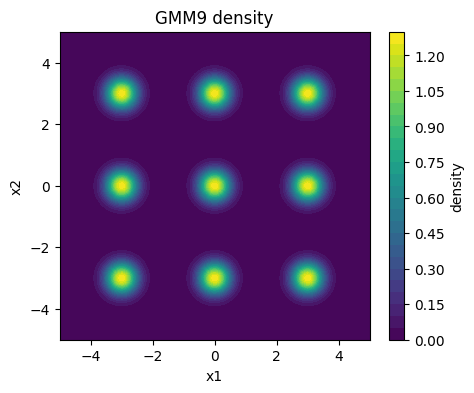

In [10]:
# Visualize the target density
fig, ax = plot_density(target.log_prob, bounds=(-5, 5), n_points=150)
ax.set_title("GMM9 density")
plt.show()

## 2) Flow model (Flax NNX)
The velocity field is a simple MLP conditioned on time via concatenation. All parameters live inside NNX modules and are mutated through the optimizer.

In [11]:
from locally_tilted_sampler.flow import FlowMLP
import flax.nnx as nnx

flow_dims = FlowDimensions(dim=2, hidden=64, depth=2)
rngs = nnx.Rngs(0)
flow = FlowMLP(flow_dims, rngs=rngs)

x = jnp.zeros((4, 2))
t = jnp.zeros((4, 1))
v = flow(x, t)
v.shape

(4, 2)

In [12]:
def print_parameter_counts(module: nnx.Module, module_name: str = "Model", max_depth: int = 3):
    """
    Print parameter counts for each layer in an nnx module with hierarchical formatting.
    
    Args:
        module: The nnx.Module to analyze
        module_name: Name to display for the root module
        max_depth: Maximum depth to traverse (default: 3)
    """
    
    def format_number(n: int) -> str:
        """Format number with thousands separator."""
        return f"{n:,}"
    
    def format_percentage(part: int, total: int) -> str:
        """Format percentage with 1 decimal place."""
        if total == 0:
            return "0.0%"
        return f"{100.0 * part / total:.1f}%"
    
    def get_param_count(state_dict) -> int:
        """Count parameters in a state dictionary."""
        count = 0
        for value in jax.tree.leaves(state_dict):
            if hasattr(value, 'size'):
                count += value.size
        return count
    
    def traverse_module(mod, name: str, depth: int, prefix: str = ""):
        """Recursively traverse module and collect parameter info."""
        # Get state for this module
        try:
            state = nnx.state(mod, nnx.Param)
        except:
            return []
        
        # Count parameters at this level
        param_count = get_param_count(state)
        
        results = []
        if param_count > 0 or depth == 0:
            results.append({
                'name': name,
                'depth': depth,
                'prefix': prefix,
                'params': param_count,
            })
        
        # Don't traverse deeper than max_depth
        if depth >= max_depth:
            return results
        
        # Get all attributes that are modules or lists of modules
        module_attrs = []
        
        # Use vars() instead of dir() to avoid sorting issues
        try:
            obj_dict = vars(mod)
        except TypeError:
            obj_dict = {}
        
        for attr_name, attr_value in obj_dict.items():
            # Skip non-string keys and private attributes
            if not isinstance(attr_name, str) or attr_name.startswith('_'):
                continue
            try:
                if isinstance(attr_value, nnx.Module):
                    module_attrs.append((attr_name, attr_value))
                elif isinstance(attr_value, (list, tuple, nnx.List)):
                    for idx, item in enumerate(attr_value):
                        if isinstance(item, nnx.Module):
                            module_attrs.append((f"{attr_name}[{idx}]", item))
            except:
                continue
        
        # Sort by name for consistent ordering
        module_attrs.sort(key=lambda x: x[0])
        
        # Traverse submodules
        for i, (attr_name, submod) in enumerate(module_attrs):
            # Create proper prefix for tree structure
            is_last = (i == len(module_attrs) - 1)
            branch = "└── " if is_last else "├── "
            new_prefix = prefix + ("    " if is_last else "│   ")
            
            sub_results = traverse_module(submod, attr_name, depth + 1, new_prefix)
            for result in sub_results:
                if result['depth'] == depth + 1:
                    result['prefix'] = prefix + branch
                results.append(result)
        
        return results
    
    # Collect all parameter info
    total_params = get_param_count(nnx.state(module, nnx.Param))
    results = traverse_module(module, module_name, 0)
    
    # Print header
    print("=" * 80)
    print(f"Parameter Count Analysis: {module_name}")
    print("=" * 80)
    print()
    
    # Print results
    max_name_len = max(len(r['prefix'] + r['name']) for r in results)
    
    for result in results:
        full_name = result['prefix'] + result['name']
        params = result['params']
        pct = format_percentage(params, total_params)
        
        # Format with aligned columns
        name_str = full_name.ljust(max_name_len + 2)
        param_str = format_number(params).rjust(12)
        pct_str = pct.rjust(8)
        
        # Add visual indicator for size
        bar_width = 30
        filled = int(bar_width * params / total_params) if total_params > 0 else 0
        bar = "█" * filled + "░" * (bar_width - filled)
        
        print(f"{name_str} {param_str} params  {pct_str}  [{bar}]")
    
    print()
    print("─" * 80)
    print(f"{'TOTAL'.ljust(max_name_len + 2)} {format_number(total_params).rjust(12)} params  100.0%")
    print("=" * 80)
    print()
    
    # Summary statistics
    if len(results) > 1:
        param_counts = [r['params'] for r in results if r['depth'] == 1]
        if param_counts:
            print("Summary Statistics (depth=1 modules):")
            print(f"  - Number of modules: {len(param_counts)}")
            print(f"  - Largest module: {format_number(max(param_counts))} params")
            print(f"  - Smallest module: {format_number(min(param_counts))} params")
            print(f"  - Average module: {format_number(int(np.mean(param_counts)))} params")
            print()

In [13]:
print_parameter_counts(flow, module_name="FlowMLP", max_depth=3)

Parameter Count Analysis: FlowMLP

FlowMLP             8,706 params    100.0%  [██████████████████████████████]
├── hidden          8,320 params     95.6%  [████████████████████████████░░]
├── input             256 params      2.9%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
└── output            130 params      1.5%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

────────────────────────────────────────────────────────────────────────────────
TOTAL               8,706 params  100.0%

Summary Statistics (depth=1 modules):
  - Number of modules: 3
  - Largest module: 8,320 params
  - Smallest module: 130 params
  - Average module: 2,902 params



## 3) Loss: segment flow matching
Sampling pairs `(x_ts, x_te)` from importance resampling, draw random `t`, and regress the velocity toward the segment displacement.

In [14]:
from locally_tilted_sampler.segment_flow_matching import compute_weighted_loss

key = jax.random.PRNGKey(1)
x_ts = target.sample(key, (16,))
x_te = x_ts + 0.1 * jax.random.normal(key, x_ts.shape)
loss = compute_weighted_loss(flow, key, x_ts, x_te, jump_kernel_std=0.0)
loss

Array(0.5358509, dtype=float32)

## 4) Training loop
Uses `nnx.Optimizer` + Optax AdamW. Each time slice trains its own flow, then propagates samples through that flow to become the next slice's starting point.

In [15]:
mini_config = TrainingConfig(
    time_slices=16,
    solver_substeps=8,
    lr=1e-3,
    epochs=50,
    train_samples=512,
    train_batch_size=128,
    seed=42,
)

train_result = train_locally_tilted_sampler(
    flow_dims=FlowDimensions(dim=2, hidden=64, depth=2),
    prior=prior,
    target=target,
    config=mini_config,
)
train_result.loss_log

[0.0002683246857486665,
 0.0017166128382086754,
 0.0056811245158314705,
 0.0018132575787603855,
 0.00011130279017379507,
 0.0011260464088991284,
 0.0002683575148694217,
 0.00039771076990291476,
 0.000660652935039252,
 0.005058874376118183,
 0.0005650846287608147,
 0.00034711978514678776,
 0.0007147911819629371,
 0.0014462583931162953,
 0.00027234310982748866,
 0.0006009517819620669]

## 5) Propagated samples snapshot
Plot the final sample distribution against the target density to inspect mode coverage.

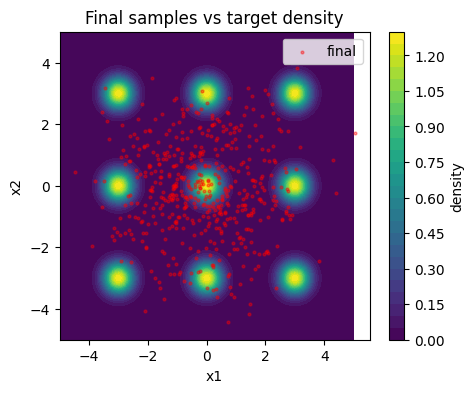

In [16]:
final_samples = jnp.array(train_result.final_samples)
fig, ax = plot_density(target.log_prob, bounds=(-5, 5), n_points=150)
ax.scatter(final_samples[:, 0], final_samples[:, 1], s=4, c="r", alpha=0.4, label="final")
ax.legend()
ax.set_title("Final samples vs target density")
plt.show()